In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statistics import variance
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

In [4]:
import json
import rich.progress

with rich.progress.open("data/data.json", "rb") as file:
    json_data = [json.loads(line) for line in file]

Output()

In [5]:
label_df = pd.read_csv("data/data.info")

In [97]:
all_rows = []

for list_index in tqdm(range(len(json_data))):
    #print(json_data[list_index])
    for gene_id in json_data[list_index]:
        for pos in json_data[list_index][gene_id]:
            for bases in json_data[list_index][gene_id][pos]:
                reads = json_data[list_index][gene_id][pos][bases]
                avg_reads = [sum(x)/len(x) for x in zip(*reads)]
                #variance_reads = [variance(x) for x in zip(*reads)]
                n_reads = [len(reads)]
                one_row = [gene_id, int(pos), bases] + avg_reads + n_reads #+ variance_reads
                all_rows.append(one_row)

100%|██████████| 121838/121838 [00:07<00:00, 16414.61it/s]


In [98]:
df = pd.DataFrame(all_rows, columns =['transcript_id', 'transcript_position', 'bases', 
'Prev_Pos_mean_of_DT', 'Prev_Pos_mean_of_SD', 'Prev_Pos_mean_of_Mean', 
'Curr_Pos_mean_of_DT', 'Curr_Pos_mean_of_SD', 'Curr_Pos_mean_of_Mean',
'Next_Pos_mean_of_DT', 'Next_Pos_mean_of_SD', 'Next_Pos_mean_of_Mean',
#'Prev_Pos_sd_of_DT', 'Prev_Pos_sd_of_SD', 'Prev_Pos_sd_of_Mean', 
#'Curr_Pos_sd_of_DT', 'Curr_Pos_sd_of_SD', 'Curr_Pos_sd_of_Mean',
#'Next_Pos_sd_of_DT', 'Next_Pos_sd_of_SD', 'Next_Pos_sd_of_Mean', 
'n_reads'])

df = df.merge(label_df, how = 'left', on = ['transcript_id', 'transcript_position'])

In [99]:
df["left_1"] = df["bases"].apply(lambda x: x[0])
df["curr_pos_bases"] = df["bases"].apply(lambda x: x[1:6])
df["right_5"] = df["bases"].apply(lambda x: x[6])

In [100]:
df["centre_1"] = df["curr_pos_bases"].apply(lambda x: x[0])
df["centre_2"] = df["curr_pos_bases"].apply(lambda x: x[1])
df["centre_3"] = df["curr_pos_bases"].apply(lambda x: x[2])
df["centre_4"] = df["curr_pos_bases"].apply(lambda x: x[3])
df["centre_5"] = df["curr_pos_bases"].apply(lambda x: x[4])

In [101]:
categorical_cols = ['left_1', 'centre_1', 'centre_2', 'centre_3', 'centre_4', 'centre_5', 'right_5']


df = pd.get_dummies(df, columns = categorical_cols)

In [102]:
df.columns

Index(['transcript_id', 'transcript_position', 'bases', 'Prev_Pos_mean_of_DT',
       'Prev_Pos_mean_of_SD', 'Prev_Pos_mean_of_Mean', 'Curr_Pos_mean_of_DT',
       'Curr_Pos_mean_of_SD', 'Curr_Pos_mean_of_Mean', 'Next_Pos_mean_of_DT',
       'Next_Pos_mean_of_SD', 'Next_Pos_mean_of_Mean', 'n_reads', 'gene_id',
       'label', 'curr_pos_bases', 'left_1_A', 'left_1_C', 'left_1_G',
       'left_1_T', 'centre_1_A', 'centre_1_G', 'centre_1_T', 'centre_2_A',
       'centre_2_G', 'centre_3_A', 'centre_4_C', 'centre_5_A', 'centre_5_C',
       'centre_5_T', 'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T'],
      dtype='object')

In [103]:
expected_columns = ['left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
                    'centre_1_A', 'centre_1_G', 'centre_1_T', 
                    'centre_2_A', 'centre_2_G', 
                    #'centre_3_A',
                    #'centre_4_C',
                    'centre_5_A', 'centre_5_C', 'centre_5_T',
                    'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T']

In [104]:
added_cols = []
df_cols = df.columns
for col in expected_columns:
    if col not in df_cols:
        df[col] = [0 for i in range(len(df))]
        added_cols.append(col)

In [105]:
ordered_columns = ['transcript_id', 'transcript_position', 'bases', 'gene_id', 
       'Prev_Pos_mean_of_DT', 'Prev_Pos_mean_of_SD', 'Prev_Pos_mean_of_Mean', 
       'Curr_Pos_mean_of_DT', 'Curr_Pos_mean_of_SD', 'Curr_Pos_mean_of_Mean',
       'Next_Pos_mean_of_DT', 'Next_Pos_mean_of_SD', 'Next_Pos_mean_of_Mean',
       #'Prev_Pos_sd_of_DT', 'Prev_Pos_sd_of_SD', 'Prev_Pos_sd_of_Mean', 
       #'Curr_Pos_sd_of_DT', 'Curr_Pos_sd_of_SD', 'Curr_Pos_sd_of_Mean',
       #'Next_Pos_sd_of_DT', 'Next_Pos_sd_of_SD', 'Next_Pos_sd_of_Mean', 
       'n_reads',
       'left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
       'centre_1_A', 'centre_1_G', 'centre_1_T', 
       'centre_2_A', 'centre_2_G', 
       #'centre_3_A',
       #'centre_4_C',
       'centre_5_A', 'centre_5_C', 'centre_5_T',
       'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T', 'label']

In [106]:
df = df[ordered_columns]

In [107]:
df2 = df.drop(['transcript_id', 'transcript_position', 'bases'], axis = 1)

In [108]:
df2

,gene_id,Prev_Pos_mean_of_DT,Prev_Pos_mean_of_SD,Prev_Pos_mean_of_Mean,Curr_Pos_mean_of_DT,Curr_Pos_mean_of_SD,Curr_Pos_mean_of_Mean,Next_Pos_mean_of_DT,Next_Pos_mean_of_SD,Next_Pos_mean_of_Mean,...,centre_2_A,centre_2_G,centre_5_A,centre_5_C,centre_5_T,right_5_A,right_5_C,right_5_G,right_5_T,label
0,ENSG00000004059,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270,...,0,1,0,1,0,1,0,0,0,0
1,ENSG00000004059,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698,...,1,0,0,0,1,0,0,1,0,0
2,ENSG00000004059,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324,...,1,0,1,0,0,0,0,1,0,0
3,ENSG00000004059,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006102,2.236520,89.154000,...,1,0,1,0,0,0,0,0,1,0
4,ENSG00000004059,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788,...,0,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENSG00000167747,0.009594,3.294164,118.232877,0.007300,4.929726,116.342466,0.006555,4.005616,82.004110,...,0,1,1,0,0,0,0,0,1,1
121834,ENSG00000167747,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,0.005568,3.644638,80.497101,...,0,1,1,0,0,0,1,0,0,0
121835,ENSG00000167747,0.008161,3.918438,113.968750,0.006877,4.759687,113.562500,0.006410,2.181562,84.190625,...,0,1,1,0,0,0,1,0,0,1
121836,ENSG00000167747,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,0.006472,2.540877,82.289474,...,0,1,0,1,0,1,0,0,0,0


In [109]:
df2["id"] = df2.index

In [110]:
gene_ids = list(df2["gene_id"].unique())

In [111]:
train_ids, test_ids = train_test_split(gene_ids, train_size = 0.8)

In [112]:
tuning_train_ids, tuning_val_ids = train_test_split(train_ids, train_size = 0.7)

In [113]:
train_df = df2[df2["gene_id"].isin(train_ids)]
val_df = df2[df2["gene_id"].isin(tuning_val_ids)]
test_df = df2[df2["gene_id"].isin(test_ids)]

In [114]:
train_df.gene_id.unique()

array(['ENSG00000003056', 'ENSG00000001036', 'ENSG00000001630', ...,
       'ENSG00000029363', 'ENSG00000284707', 'ENSG00000235823'],
      dtype=object)

In [115]:
split_index = [-1 if x in val_df.id else 0 for x in train_df.id]
pds = PredefinedSplit(test_fold = split_index)

In [116]:
X_train = train_df.drop(["gene_id", "label"], axis = 1).to_numpy()
y_train = train_df[["label"]].to_numpy().ravel()

X_val = val_df.drop(["gene_id", "label"], axis = 1).to_numpy()
y_val = val_df[["label"]].to_numpy().ravel()


X_test = test_df.drop(["gene_id", "label"], axis = 1).to_numpy()
y_test = test_df[["label"]].to_numpy().ravel()

In [117]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree'],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 0.8],
    'scale_pos_weight': [5,7,14]
}

In [156]:
from sklearn.metrics import precision_recall_curve, make_scorer, auc, roc_auc_score

def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=True)

In [145]:
tuning_model = RandomizedSearchCV(XGBClassifier(), params, n_jobs=-1, cv=pds, scoring=pr_auc_scorer, n_iter = 200)
tuning_model.fit(X_train, y_train)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'base_score': [0.2, 0.5, 0.8],
                                        'booster': ['gbtree'],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'n_estimators': [100, 200, 500],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 5],
                                        'scale_pos_weight': [5, 7, 14, 21]},
                   scoring=make_scorer(pr_auc_score, needs_proba=True))

In [151]:
(pd.DataFrame(tuning_model.cv_results_)).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_n_estimators,param_learning_rate,param_booster,param_base_score,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
32,58.746427,0.0,1.050645,0.0,7,5,1,500,0.05,gbtree,0.8,"{'scale_pos_weight': 7, 'reg_lambda': 5, 'reg_...",0.417267,0.417267,0.0,1
23,21.835581,0.0,0.393473,0.0,5,5,1,200,0.1,gbtree,0.5,"{'scale_pos_weight': 5, 'reg_lambda': 5, 'reg_...",0.417127,0.417127,0.0,2
37,23.611649,0.0,0.419908,0.0,5,5,0.5,200,0.05,gbtree,0.2,"{'scale_pos_weight': 5, 'reg_lambda': 5, 'reg_...",0.416963,0.416963,0.0,3
181,25.626804,0.0,0.414039,0.0,7,5,0.5,200,0.1,gbtree,0.5,"{'scale_pos_weight': 7, 'reg_lambda': 5, 'reg_...",0.416938,0.416938,0.0,4
19,21.189486,0.0,0.368489,0.0,5,1,0.5,200,0.1,gbtree,0.2,"{'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_...",0.416721,0.416721,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,12.432519,0.0,0.229117,0.0,21,1,0.5,100,0.01,gbtree,0.8,"{'scale_pos_weight': 21, 'reg_lambda': 1, 'reg...",0.359167,0.359167,0.0,196
84,13.160655,0.0,0.200321,0.0,14,1,0.5,100,0.01,gbtree,0.5,"{'scale_pos_weight': 14, 'reg_lambda': 1, 'reg...",0.357775,0.357775,0.0,197
52,11.480281,0.0,0.219128,0.0,21,1,1,100,0.01,gbtree,0.8,"{'scale_pos_weight': 21, 'reg_lambda': 1, 'reg...",0.357533,0.357533,0.0,198
12,10.479807,0.0,0.184090,0.0,21,0.5,1,100,0.01,gbtree,0.2,"{'scale_pos_weight': 21, 'reg_lambda': 0.5, 'r...",0.344852,0.344852,0.0,199


In [149]:
tuning_model.best_params_

{'scale_pos_weight': 7,
 'reg_lambda': 5,
 'reg_alpha': 1,
 'n_estimators': 500,
 'learning_rate': 0.05,
 'booster': 'gbtree',
 'base_score': 0.8}

In [159]:
model = XGBClassifier(scale_pos_weight=5, reg_lambda= 5, reg_alpha= 1, n_estimators= 500,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.8, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=5, ...)

In [68]:
# hyperparams : XGBClassifier(reg_lambda= 5, reg_alpha= 1, n_estimators= 200,learning_rate= 0.05,booster= 'gbtree',base_score= 0.2, scale_pos_weight=5)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     23834
           1       0.45      0.52      0.48      1100

    accuracy                           0.95     24934
   macro avg       0.71      0.74      0.73     24934
weighted avg       0.95      0.95      0.95     24934



In [35]:
# hyperparams: XGBClassifier(reg_lambda= 1, reg_alpha= 1, n_estimators= 200,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8, scale_pos_weight=5)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     24382
           1       0.42      0.50      0.46      1087

    accuracy                           0.95     25469
   macro avg       0.70      0.74      0.71     25469
weighted avg       0.95      0.95      0.95     25469



In [86]:
# hyperparams: XGBClassifier(reg_lambda= 5, reg_alpha= 5, n_estimators= 100,learning_rate= 0.05,booster= 'gbtree',base_score= 0.2, scale_pos_weight=5)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     25373
           1       0.42      0.49      0.45      1034

    accuracy                           0.95     26407
   macro avg       0.70      0.73      0.71     26407
weighted avg       0.96      0.95      0.96     26407



In [39]:
# hyperparams: XGBClassifier(reg_lambda= 1, reg_alpha= 0.5, n_estimators= 100,learning_rate= 0.1,booster= 'gbtree',base_score= 0.8, scale_pos_weight=5) (auc, no SDS)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     23154
           1       0.49      0.53      0.51      1151

    accuracy                           0.95     24305
   macro avg       0.73      0.75      0.74     24305
weighted avg       0.95      0.95      0.95     24305



In [89]:
# hyperparams: XGBClassifier(reg_lambda= 1, reg_alpha= 0.5, n_estimators= 200,learning_rate= 0.05,booster= 'gbtree',base_score= 0.5, scale_pos_weight=5) (AUC-ROC, added sds)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     21814
           1       0.43      0.56      0.49       963

    accuracy                           0.95     22777
   macro avg       0.71      0.77      0.73     22777
weighted avg       0.96      0.95      0.95     22777



In [144]:
#hyperparams: XGBClassifier(reg_lambda= 5, reg_alpha= 0, n_estimators= 500,learning_rate= 0.05,booster= 'gbtree',base_score= 0.2, scale_pos_weight=5) (PR-AUC, NO SD)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     21762
           1       0.54      0.53      0.53      1227

    accuracy                           0.95     22989
   macro avg       0.76      0.75      0.75     22989
weighted avg       0.95      0.95      0.95     22989



In [148]:
#hyperparams: XGBClassifier(scale_pos_weight=7, reg_lambda= 5, reg_alpha= 1, n_estimators= 500,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8) (PR-AUC no SD more hyperparams)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     21762
           1       0.49      0.56      0.53      1227

    accuracy                           0.95     22989
   macro avg       0.73      0.76      0.75     22989
weighted avg       0.95      0.95      0.95     22989



In [160]:
#hyperparams: XGBClassifier(scale_pos_weight=5, reg_lambda= 5, reg_alpha= 1, n_estimators= 500,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8) (PR-AUC no SD)
y_pred=model.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred)) #BEST SO FAR

0.7504522137576795
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     21762
           1       0.54      0.53      0.54      1227

    accuracy                           0.95     22989
   macro avg       0.76      0.75      0.75     22989
weighted avg       0.95      0.95      0.95     22989



# EDA

<BarContainer object of 27 artists>

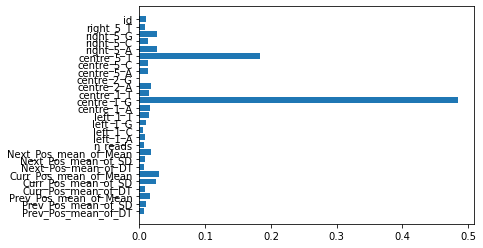

In [161]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
model.feature_importances_
plt.barh(train_df.drop(["gene_id", "label"], axis = 1).columns, model.feature_importances_)

In [44]:
train_df.drop(["gene_id", "label"], axis = 1).columns

Index(['Prev_Pos_DT', 'Prev_Pos_SD', 'Prev_Pos_Mean', 'Curr_Pos_DT',
       'Curr_Pos_SD', 'Curr_Pos_Mean', 'Next_Pos_DT', 'Next_Pos_SD',
       'Next_Pos_Mean', 'n_reads', 'left_1_A', 'left_1_C', 'left_1_G',
       'left_1_T', 'centre_1_A', 'centre_1_G', 'centre_1_T', 'centre_2_A',
       'centre_2_G', 'centre_5_A', 'centre_5_C', 'centre_5_T', 'right_5_A',
       'right_5_C', 'right_5_G', 'right_5_T', 'id'],
      dtype='object')